In [1]:
import torch
import pickle
import transformers

import numpy as np
import seaborn as sns
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

from fake_news.util import train_classifier_head
from fake_news.util import evaluate_wrapper
from fake_news.defaults import LABELS

transformers.logging.set_verbosity_error()

In [2]:
epochs = 200

_, history = train_classifier_head(
    train_set='../../preprocessed/fake_news/embeddings/train.pkl',
    experiment_dir='../../results/run_train',
    valid_set='../../preprocessed/fake_news/embeddings/valid.pkl',
    batch_size=1024,
    epochs=epochs,
    gpu=True
)

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch:   1 | train loss: 0.489 | valid loss: 0.344 | train acc: 84.0% | valid acc: 87.2% | train f1: 43.1% | valid f1: 42.6%
Epoch:   2 | train loss: 0.294 | valid loss: 0.317 | train acc: 88.5% | valid acc: 88.2% | train f1: 45.5% | valid f1: 50.5%
Epoch:   3 | train loss: 0.276 | valid loss: 0.306 | train acc: 89.2% | valid acc: 89.7% | train f1: 50.5% | valid f1: 57.1%
Epoch:   4 | train loss: 0.263 | valid loss: 0.295 | train acc: 90.0% | valid acc: 89.9% | train f1: 54.0% | valid f1: 57.8%
Epoch:   5 | train loss: 0.254 | valid loss: 0.286 | train acc: 90.6% | valid acc: 89.9% | train f1: 56.1% | valid f1: 57.6%
Epoch:   6 | train loss: 0.247 | valid loss: 0.284 | train acc: 90.8% | valid acc: 89.7% | train f1: 56.8% | valid f1: 56.9%
Epoch:   7 | train loss: 0.243 | valid loss: 0.277 | train acc: 91.0% | valid acc: 90.0% | train f1: 57.4% | valid f1: 57.6%
Epoch:   8 | train loss: 0.237 | valid loss: 0.278 | train acc: 91.2% | valid acc: 90.4% | train f1: 58.2% | valid f1: 59.0%


Min valid loss at epoch: 79


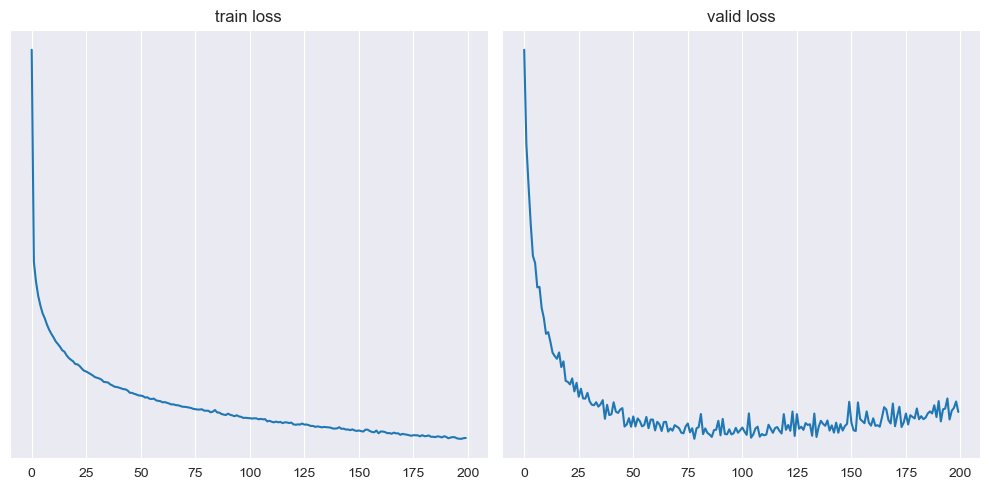

In [3]:
_, ax = plt.subplots(1, 2, figsize=(10, 5))

sns.lineplot(x=np.arange(epochs), y=history['train']['loss'], ax=ax[0])
sns.lineplot(x=np.arange(epochs), y=history['valid']['loss'], ax=ax[1])

ax[0].set_title('train loss')
ax[1].set_title('valid loss')
ax[0].get_yaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)
plt.tight_layout()

early_stopping = np.argmin(history['valid']['loss']) + 1

print(f'Min valid loss at epoch: {early_stopping}')

In [4]:
# Retrain the model on train, valid & none set until an early stopping criterion
all_embeddings = {'X': [], 'y': []}

for split in ['train', 'valid', 'none']:
    with open(f'../../preprocessed/fake_news/embeddings/{split}.pkl', 'rb') as file:
        data = pickle.load(file)

    all_embeddings['X'] += [data['X']]
    all_embeddings['y'] += [data['y']]

all_embeddings['X'] = torch.cat(all_embeddings['X'])
all_embeddings['y'] = torch.cat(all_embeddings['y'])

with open(f'../../preprocessed/fake_news/embeddings/all.pkl', 'wb') as file:
    pickle.dump(all_embeddings, file)

In [5]:
model, _ = train_classifier_head(
    train_set='../../preprocessed/fake_news/embeddings/all.pkl',
    experiment_dir='../../results/run_all',
    batch_size=1024,
    epochs=early_stopping,
    gpu=True
)

torch.save(model.head, '../../models/fake_news/fake_news_classifier.pth')

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch:   1 | train loss: 0.471 | train acc: 82.9% | train f1: 43.1% | 
Epoch:   2 | train loss: 0.285 | train acc: 89.1% | train f1: 49.4% | 
Epoch:   3 | train loss: 0.267 | train acc: 89.9% | train f1: 53.3% | 
Epoch:   4 | train loss: 0.256 | train acc: 90.3% | train f1: 55.5% | 
Epoch:   5 | train loss: 0.247 | train acc: 90.6% | train f1: 56.6% | 
Epoch:   6 | train loss: 0.240 | train acc: 90.9% | train f1: 57.5% | 
Epoch:   7 | train loss: 0.234 | train acc: 91.1% | train f1: 58.0% | 
Epoch:   8 | train loss: 0.230 | train acc: 91.2% | train f1: 58.3% | 
Epoch:   9 | train loss: 0.225 | train acc: 91.5% | train f1: 59.1% | 
Epoch:  10 | train loss: 0.221 | train acc: 91.5% | train f1: 59.7% | 
Epoch:  11 | train loss: 0.219 | train acc: 91.6% | train f1: 59.9% | 
Epoch:  12 | train loss: 0.216 | train acc: 91.8% | train f1: 60.3% | 
Epoch:  13 | train loss: 0.213 | train acc: 91.8% | train f1: 60.5% | 
Epoch:  14 | train loss: 0.211 | train acc: 92.0% | train f1: 61.1% | 
Epoch:

# Evaluation

In [6]:
model_path = '../../models/fake_news/fake_news_classifier.pth'
train_dataset = '../../preprocessed/fake_news/embeddings/all.pkl'
test_dataset = '../../preprocessed/fake_news/embeddings/test.pkl'
batch_size = 1024

_, y_true_train, y_pred_train = evaluate_wrapper(model_path, train_dataset, batch_size=1024, gpu=True)
_, y_true_test, y_pred_test = evaluate_wrapper(model_path, test_dataset, batch_size=1024, gpu=True)

**Dummy Baseline**
- always return unrelated

In [7]:
dummy_pred = [0] * len(y_true_test)

print(metrics.classification_report(y_true_test, dummy_pred, target_names=LABELS))

              precision    recall  f1-score   support

   unrelated       0.72      1.00      0.84     17856
       agree       0.00      0.00      0.00      1863
    disagree       0.00      0.00      0.00       696
     discuss       0.00      0.00      0.00      4363

    accuracy                           0.72     24778
   macro avg       0.18      0.25      0.21     24778
weighted avg       0.52      0.72      0.60     24778



C:\Users\Marcin\miniconda3\envs\sages\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Marcin\miniconda3\envs\sages\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Marcin\miniconda3\envs\sages\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

   unrelated       0.99      0.99      0.99     36262
       agree       0.74      0.67      0.70      3643
    disagree       0.70      0.24      0.36       829
     discuss       0.82      0.91      0.86      8804

    accuracy                           0.94     49538
   macro avg       0.82      0.70      0.73     49538
weighted avg       0.94      0.94      0.94     49538



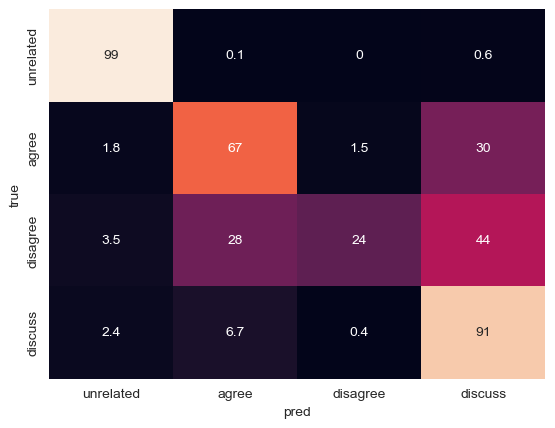

In [8]:
# Train set performance
print(metrics.classification_report(y_true_train, y_pred_train, target_names=LABELS))

cm = metrics.confusion_matrix(y_true_train, y_pred_train, normalize='true')
annot = np.round(cm * 100, 1)
ax = sns.heatmap(cm, cbar=False, annot=annot, xticklabels=LABELS, yticklabels=LABELS)

ax.set_xlabel('pred')
ax.set_ylabel('true');

              precision    recall  f1-score   support

   unrelated       0.98      0.98      0.98     17856
       agree       0.46      0.59      0.51      1863
    disagree       0.25      0.04      0.06       696
     discuss       0.73      0.75      0.74      4363

    accuracy                           0.89     24778
   macro avg       0.61      0.59      0.58     24778
weighted avg       0.88      0.89      0.88     24778



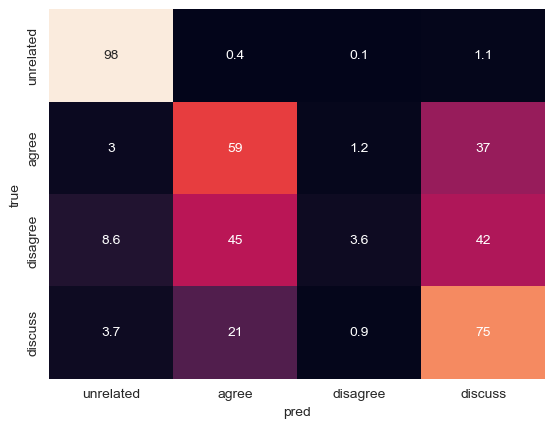

In [9]:
# Test set performance
print(metrics.classification_report(y_true_test, y_pred_test, target_names=LABELS))

cm = metrics.confusion_matrix(y_true_test, y_pred_test, normalize='true')
annot = np.round(cm * 100, 1)
ax = sns.heatmap(cm, cbar=False, annot=annot, xticklabels=LABELS, yticklabels=LABELS)

ax.set_xlabel('pred')
ax.set_ylabel('true');

### Ideas
- Using ensemble of classifiers selecting their most common prediction would improve performance.